## Prerequisites

In [38]:
# imports
import pandas as pd
import os
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

At any point in the analysis, the configurations can be accessed through the `configs` dataframe.

In [2]:
# configurations for reference
configs = pd.DataFrame(
    {
        'ConfigNr': range(1, 19),
        'FriendRecTechnique': ['Hyb', 'NoN', 'Rdm'] * 6,
        'UnfriendThresh': (['low'] * 3 + ['medium'] * 3 + ['high'] * 3) * 2,
        'AgentCount': [100] * 9 + [1000] * 9
    }
)

## Helper functions

***Format and combine.*** For some inquiries, we need to concatenate dataframes from different runs. The formatting can be simplified with the following function.

In [3]:
# combine dataframes to investigate experiment variables
def format_combine(data_dict, keys):
    return pd.concat(
        [data_dict[keys[i]] for i in range(len(keys))],
        axis=0
    ).reset_index(drop=True).drop('Component', axis=1)

## Load Data

In [4]:
# load data
data = {}
for idx in range(len(configs)):
    cfg = configs.iloc[idx, 1] + '_' + configs.iloc[idx, 2] + '_' + str(configs.iloc[idx, 3])
    data[cfg] = pd.read_csv(os.path.join('dataexchange', 'BAv2_run' + str(idx + 1).zfill(2), 'agent_log.csv'))
    data[cfg]['FriendRecScheme'] = configs.iloc[idx, 1]
    data[cfg]['UnfriendThresh'] = configs.iloc[idx, 2]
    data[cfg]['AgentCount'] = str(configs.iloc[idx, 3])

In [5]:
# create complete dataframe
df = format_combine(data, list(data.keys()))

In [6]:
df.head()

,TickNr,AgentID,Opinion,PerceivPublOpinion,Indegree,Outdegree,Centrality,CC,FriendRecScheme,UnfriendThresh,AgentCount
0,1,1,0.303008,-0.034709,26,28,0.575581,0.053809,Hyb,low,100
1,1,2,0.766807,-0.225914,26,28,0.582353,0.065339,Hyb,low,100
2,1,3,0.802710,-0.267763,31,30,0.589286,0.049727,Hyb,low,100
3,1,4,-0.232500,-0.343877,11,11,0.492537,0.038961,Hyb,low,100
4,1,5,0.403752,0.224035,22,22,0.559322,0.063425,Hyb,low,100


## Idea 1: Build Models on Final States

### Linear Model

The following is a linear regression model to predict an agent's opinion from the other attributes. 

In [7]:
# subset data to retain only final state
model_1_data = df[df['TickNr'] == 1000]
model_1_data = model_1_data.loc[
    :, 
    [
        'PerceivPublOpinion', 
        'Indegree', 
        'Outdegree', 
        'Centrality', 
        'CC', 
        'Opinion'
    ]
]

In [8]:
# scale data to [0, 1]
for col_name in ['PerceivPublOpinion', 'Indegree', 'Outdegree', 'Opinion']:
    mms = MinMaxScaler()
    model_1_data[col_name] = mms.fit_transform(model_1_data[[col_name]])

In [9]:
# split data into features and label
X = model_1_data.drop(['Opinion'], axis=1).values
y = model_1_data['Opinion']

In [10]:
# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [11]:
# fit linear regression estimator
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# predict test data
y_pred = lm.predict(X_test)

In [13]:
# performance metrics
lm.score(X_test, y_test)

0.802048393507757

## Combination with Network Log

In [47]:
hyb_low_100_graph = nx.read_gml(os.path.join('dataexchange', 'BAv2_run01', 'graph_11.gml'), label=None)

In [40]:
opinion = df[
    (df['FriendRecScheme'] == 'Hyb') 
    & (df['UnfriendThresh'] == 'low') 
    & (df['AgentCount'] == '100') 
    & (df['TickNr'] == 1000)
]['Opinion']

In [50]:
nx.is_connected(hyb_low_100_graph.to_undirected())

False

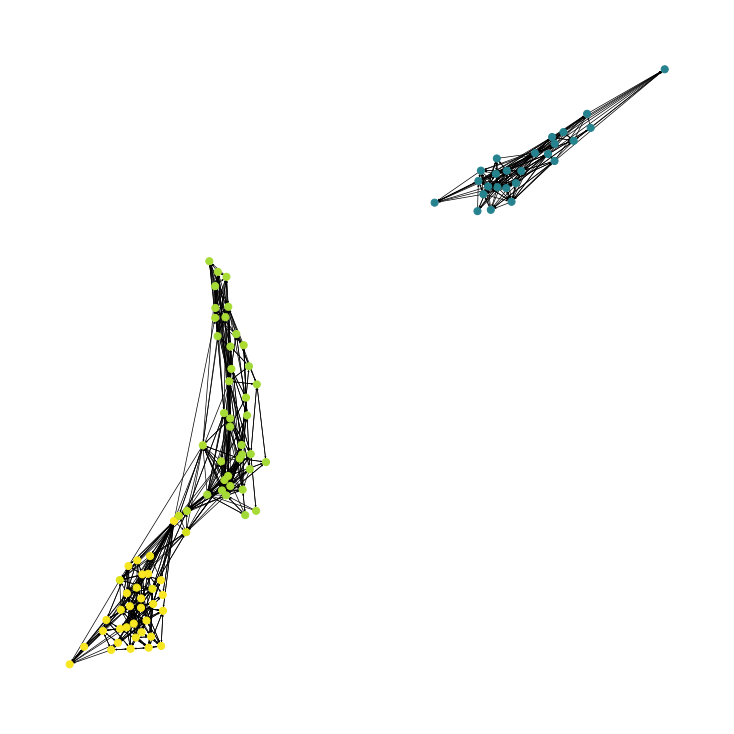

In [57]:
plt.figure(figsize=(10, 10))
nx.draw_spring(hyb_low_100_graph, arrowsize=3, node_size=50, width=0.7, cmap=cm.get_cmap('viridis'), vmin=-1, cmax=1, node_color=opinion)